In [2]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [3]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [4]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [5]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [6]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values
    train_ua = train['ua'][:, :12].values
    train_va = train['va'][:, :12].values
    train_label = label['nino'][:, 12:36].values

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
#     data_list = [train_sst,train_t300,train_ua,train_va]
#     train_sst,train_t300,train_ua,train_va = fit_data(data_list, fit=True)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values
    train_ua2 = train2['ua'][:, :12].values
    train_va2 = train2['va'][:, :12].values
    train_label2 = label2['nino'][:, 12:36].values
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
#     data_list = [train_sst2,train_t3002,train_ua2,train_va2]
#     train_sst2,train_t3002,train_ua2,train_va2 = fit_data(data_list, fit=False)

    print('Train samples: {}, Valid samples: {}'.format(len(train_label), len(train_label2)))

    dict_train = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_valid = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    train_dataset = EarthDataSet(dict_train)
    valid_dataset = EarthDataSet(dict_valid)
    return train_dataset, valid_dataset

In [7]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Train samples: 4645, Valid samples: 100


In [8]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds)
        y_true.append(label)

    y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
    y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    print('Epoch: {}, Valid Score: {}\n'.format(epoch+1,score))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(24):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(loss_epoch)),loss_epoch)
        plt.tight_layout()
        plt.show()
        

In [112]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        resnet = models.resnet18()
        resnet.conv1 = nn.Conv2d(12, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
        resnet.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.resnet1 = nn.Sequential(*(list(resnet.children())[:-1]))
        self.resnet2 = nn.Sequential(*(list(resnet.children())[:-1]))
        self.resnet3 = nn.Sequential(*(list(resnet.children())[:-1]))
        self.resnet4 = nn.Sequential(*(list(resnet.children())[:-1]))
        
#         self.conv1 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
#         self.conv2 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
#         self.conv3 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
#         self.conv4 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        
        self.batch_norm = nn.BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True)
#         self.lstm = nn.LSTM(input_size = 1540 * 4, hidden_size = 256, num_layers=2, batch_first=True, bidirectional=False)
#         self.avgpool = nn.AdaptiveAvgPool2d((1,64))
        self.linear0 = nn.Linear(2048, 64)
        self.tanh = nn.Tanh()
        self.linear = nn.Linear(64, 24)

    def forward(self, sst, t300, ua, va):
        sst = self.resnet1(sst).squeeze(-1).squeeze(-1)  # batch * 12 * (24 - 2) * (72 -2)
        t300 = self.resnet2(t300).squeeze(-1).squeeze(-1)
        ua = self.resnet3(ua).squeeze(-1).squeeze(-1)
        va = self.resnet4(va).squeeze(-1).squeeze(-1)
        
#         sst = torch.flatten(sst, start_dim=1)  # batch * 12 * 1540
#         t300 = torch.flatten(t300, start_dim=1)
#         ua = torch.flatten(ua, start_dim=1)
#         va = torch.flatten(va, start_dim=1)  
        
        x = torch.cat([sst, t300, ua, va], dim=-1) # batch * 12 * (1540 * 4)
#         x = torch.flatten(x, start_dim=1)
#         x, (h_n, c_n) = self.lstm(x)
#         x = x[:,-1]
#         x = self.avgpool(x.unsqueeze(-2)).squeeze(dim=-2)
        x = self.linear0(x)
        x = self.tanh(x)
        x = self.linear(x)
        return x

In [113]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=6e-5)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [114]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 11.324400M


In [115]:
model

CNN_Model(
  (resnet1): Sequential(
    (0): Conv2d(12, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

acskill_socre:1.724926576417917, rmse_score:20.09734232057449
Epoch: 0, Valid Score: -18.372415744156573

Step: 0, Train Loss: 0.5885201692581177
Step: 20, Train Loss: 0.7315897345542908
Step: 40, Train Loss: 0.7131990194320679
Step: 60, Train Loss: 0.6664731502532959
Step: 80, Train Loss: 0.6481360197067261
Step: 100, Train Loss: 0.5622576475143433
Step: 120, Train Loss: 0.7309383153915405
Step: 140, Train Loss: 0.4688149690628052
Epoch: 1, Train loss: 0.619992609505784
acskill_socre:20.31012466038784, rmse_score:18.527833286885844
Epoch: 1, Valid Score: 1.7822913735019945
Model saved successfully


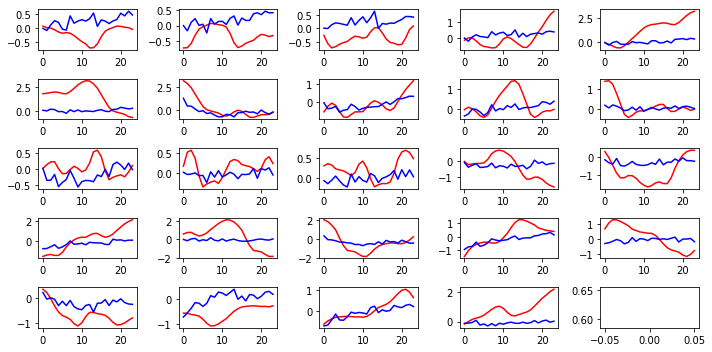

Step: 0, Train Loss: 0.5297965407371521
Step: 20, Train Loss: 0.5163962841033936
Step: 40, Train Loss: 0.399554967880249
Step: 60, Train Loss: 0.38788363337516785
Step: 80, Train Loss: 0.5777249336242676
Step: 100, Train Loss: 0.36187049746513367
Step: 120, Train Loss: 0.418706476688385
Step: 140, Train Loss: 0.32379281520843506
Epoch: 2, Train loss: 0.43935590615011244
acskill_socre:20.668451094483192, rmse_score:17.818539679452222
Epoch: 2, Valid Score: 2.84991141503097
Model saved successfully


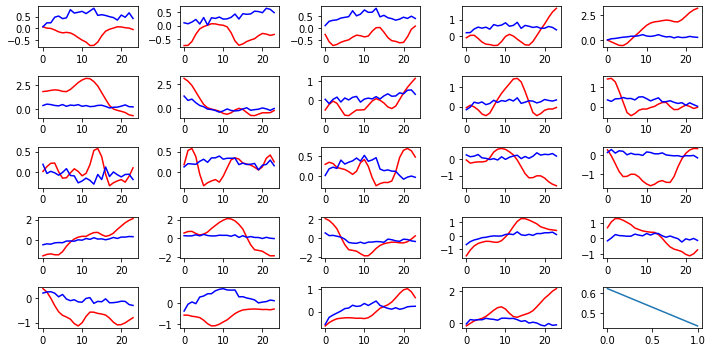

Step: 0, Train Loss: 0.37071263790130615
Step: 20, Train Loss: 0.3004331588745117
Step: 40, Train Loss: 0.254243940114975
Step: 60, Train Loss: 0.19327382743358612
Step: 80, Train Loss: 0.19359898567199707
Step: 100, Train Loss: 0.2814810872077942
Step: 120, Train Loss: 0.30570679903030396
Step: 140, Train Loss: 0.12462948262691498
Epoch: 3, Train loss: 0.2391060385597895
acskill_socre:18.427653474064364, rmse_score:18.6818115784542
Epoch: 3, Valid Score: -0.25415810438983755


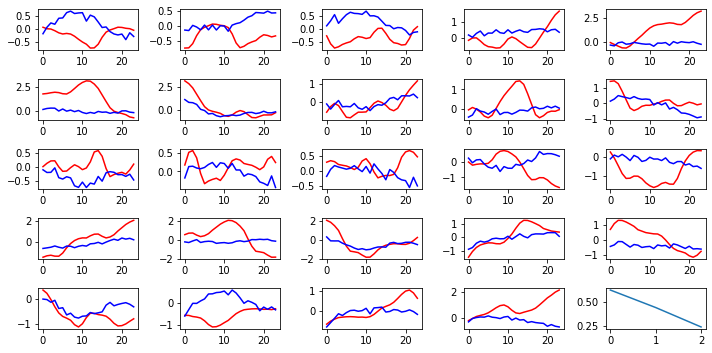

Step: 0, Train Loss: 0.10457231104373932
Step: 20, Train Loss: 0.18424086272716522
Step: 40, Train Loss: 0.1473197042942047
Step: 60, Train Loss: 0.13073770701885223
Step: 80, Train Loss: 0.16917023062705994
Step: 100, Train Loss: 0.16149616241455078
Step: 120, Train Loss: 0.1998647153377533
Step: 140, Train Loss: 0.16322088241577148
Epoch: 4, Train loss: 0.1557299827978219
acskill_socre:18.52807793827308, rmse_score:19.57808806234206
Epoch: 4, Valid Score: -1.050010124068983


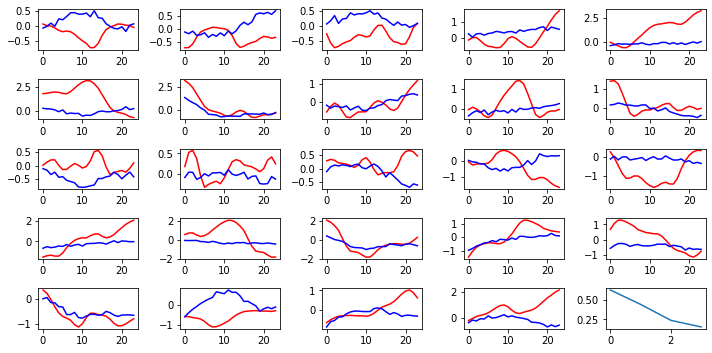

Step: 0, Train Loss: 0.1325693577528
Step: 20, Train Loss: 0.1302565038204193
Step: 40, Train Loss: 0.12263789027929306
Step: 60, Train Loss: 0.10640664398670197
Step: 80, Train Loss: 0.13217464089393616
Step: 100, Train Loss: 0.08840040862560272
Step: 120, Train Loss: 0.10163663327693939
Step: 140, Train Loss: 0.11288110911846161
Epoch: 5, Train loss: 0.13583848176345434
acskill_socre:19.77585462786903, rmse_score:18.116793312344225
Epoch: 5, Valid Score: 1.6590613155248057


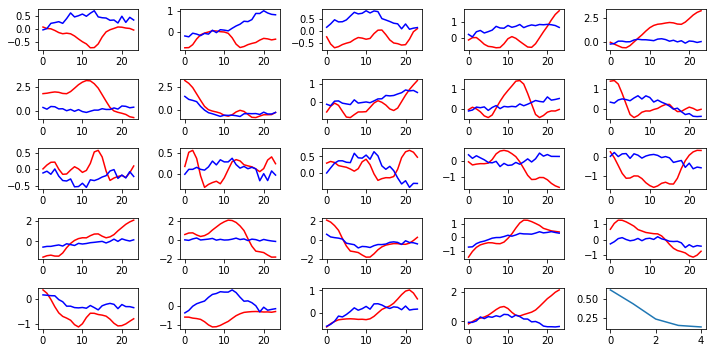

Step: 0, Train Loss: 0.1564147174358368
Step: 20, Train Loss: 0.08104713261127472
Step: 40, Train Loss: 0.11374609172344208
Step: 60, Train Loss: 0.11935679614543915
Step: 80, Train Loss: 0.1248435229063034
Step: 100, Train Loss: 0.14285582304000854
Step: 120, Train Loss: 0.07454025000333786
Step: 140, Train Loss: 0.0931505560874939
Epoch: 6, Train loss: 0.11744890897853734
acskill_socre:17.74570464058018, rmse_score:18.356810904300996
Epoch: 6, Valid Score: -0.6111062637208171


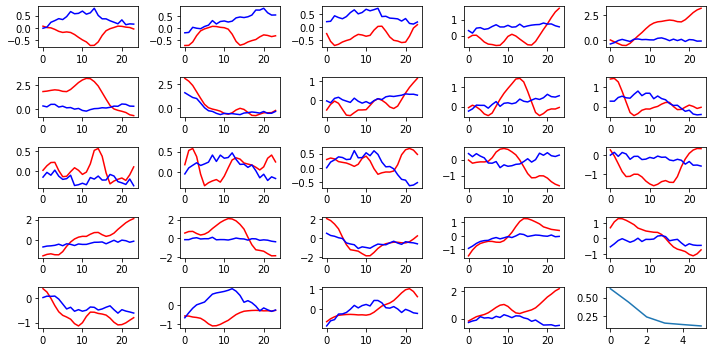

Step: 0, Train Loss: 0.07105846703052521
Step: 20, Train Loss: 0.07574354857206345
Step: 40, Train Loss: 0.1356751024723053
Step: 60, Train Loss: 0.10160279273986816
Step: 80, Train Loss: 0.07115225493907928
Step: 100, Train Loss: 0.15752668678760529
Step: 120, Train Loss: 0.061586543917655945
Step: 140, Train Loss: 0.11343558877706528
Epoch: 7, Train loss: 0.1021827857124887
acskill_socre:21.15659755336267, rmse_score:18.343515870090993
Epoch: 7, Valid Score: 2.813081683271676


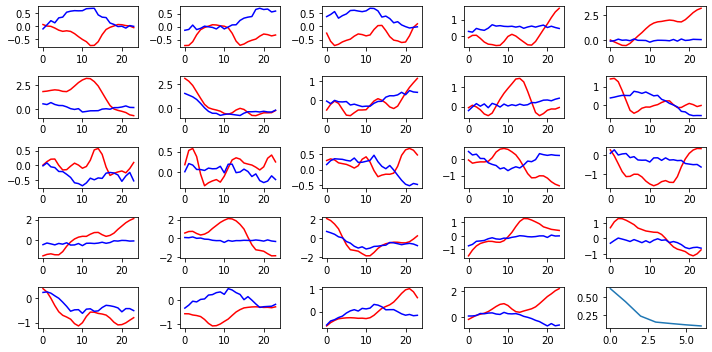

Step: 0, Train Loss: 0.08228737115859985
Step: 20, Train Loss: 0.09198325127363205
Step: 40, Train Loss: 0.06763793528079987
Step: 60, Train Loss: 0.07638588547706604
Step: 80, Train Loss: 0.11321976780891418
Step: 100, Train Loss: 0.11882869899272919
Step: 120, Train Loss: 0.10406860709190369
Step: 140, Train Loss: 0.06382977217435837
Epoch: 8, Train loss: 0.09030888176025594
acskill_socre:19.231775908129737, rmse_score:18.144725953826256
Epoch: 8, Valid Score: 1.087049954303481


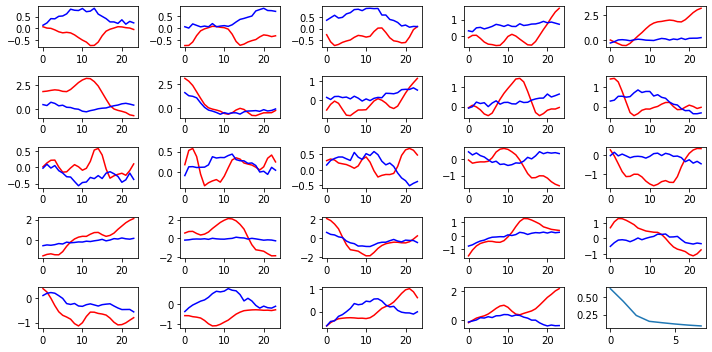

Step: 0, Train Loss: 0.06948448717594147
Step: 20, Train Loss: 0.07976745069026947
Step: 40, Train Loss: 0.08311206102371216
Step: 60, Train Loss: 0.07963694632053375
Step: 80, Train Loss: 0.061335235834121704
Step: 100, Train Loss: 0.07592295110225677
Step: 120, Train Loss: 0.04809848591685295
Step: 140, Train Loss: 0.08678454160690308
Epoch: 9, Train loss: 0.08415863389940295
acskill_socre:18.949377079515116, rmse_score:18.35237236268783
Epoch: 9, Valid Score: 0.5970047168272856


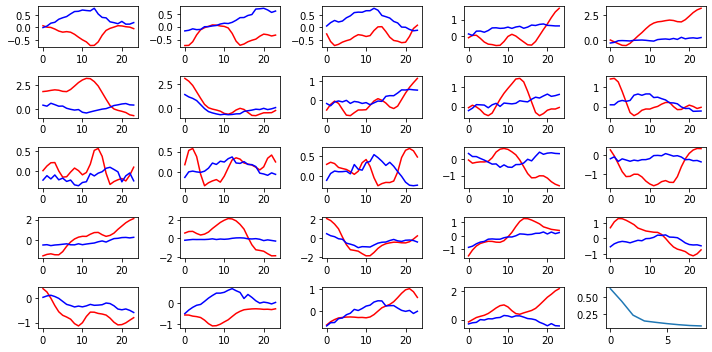

Step: 0, Train Loss: 0.11837659776210785
Step: 20, Train Loss: 0.08659198135137558
Step: 40, Train Loss: 0.06778552383184433
Step: 60, Train Loss: 0.05883389711380005
Step: 80, Train Loss: 0.05112361162900925
Step: 100, Train Loss: 0.05664719268679619
Step: 120, Train Loss: 0.09807049483060837
Step: 140, Train Loss: 0.07852423191070557
Epoch: 10, Train loss: 0.08341957554731468
acskill_socre:18.7403921154093, rmse_score:18.458395265311825
Epoch: 10, Valid Score: 0.28199685009747455


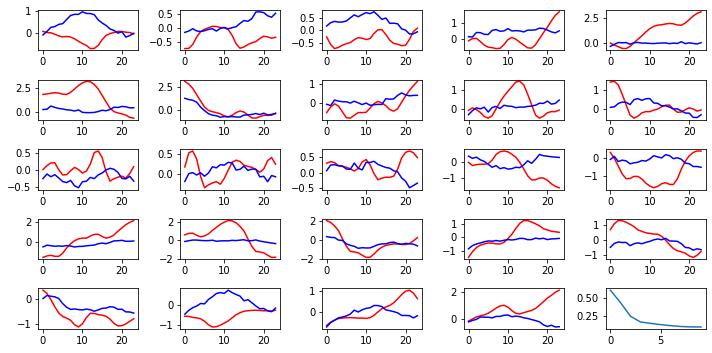

Step: 0, Train Loss: 0.054499685764312744
Step: 20, Train Loss: 0.06798022240400314
Step: 40, Train Loss: 0.07266049832105637
Step: 60, Train Loss: 0.06297600269317627
Step: 80, Train Loss: 0.054799579083919525
Step: 100, Train Loss: 0.07524342834949493
Step: 120, Train Loss: 0.09385031461715698
Step: 140, Train Loss: 0.051709067076444626
Epoch: 11, Train loss: 0.07283489668920431
acskill_socre:19.97460185488781, rmse_score:18.18240465763992
Epoch: 11, Valid Score: 1.7921971972478872


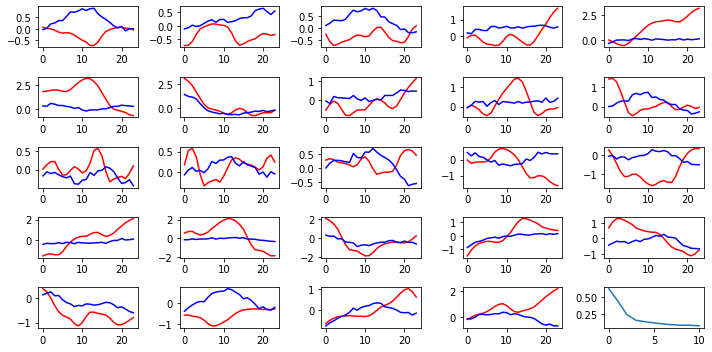

Step: 0, Train Loss: 0.0769423320889473
Step: 20, Train Loss: 0.10284483432769775
Step: 40, Train Loss: 0.04376756772398949
Step: 60, Train Loss: 0.053117088973522186
Step: 80, Train Loss: 0.05393698066473007
Step: 100, Train Loss: 0.05527978390455246
Step: 120, Train Loss: 0.04029936343431473
Step: 140, Train Loss: 0.05520079284906387
Epoch: 12, Train loss: 0.06728926329069758
acskill_socre:18.175634556517203, rmse_score:18.027608863369377
Epoch: 12, Valid Score: 0.14802569314782588


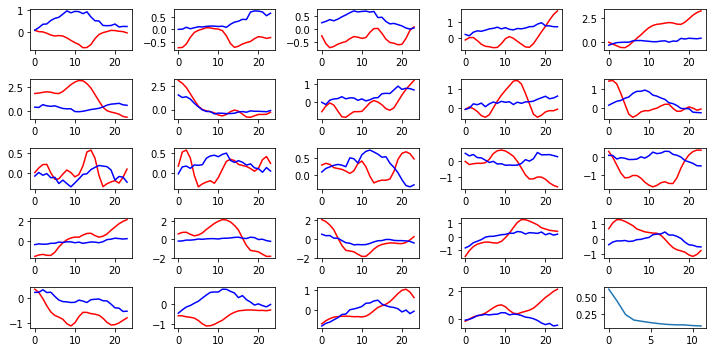

Step: 0, Train Loss: 0.04613330960273743
Step: 20, Train Loss: 0.09578973054885864
Step: 40, Train Loss: 0.030961092561483383
Step: 60, Train Loss: 0.08825010061264038
Step: 80, Train Loss: 0.036660924553871155
Step: 100, Train Loss: 0.0692005529999733
Step: 120, Train Loss: 0.0430857390165329
Step: 140, Train Loss: 0.15193377435207367
Epoch: 13, Train loss: 0.06397117933334961
acskill_socre:18.863274698370656, rmse_score:18.047408621905106
Epoch: 13, Valid Score: 0.8158660764655501


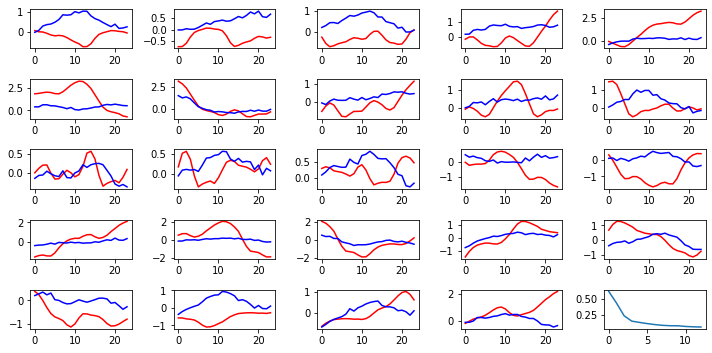

Step: 0, Train Loss: 0.1185203418135643
Step: 20, Train Loss: 0.17139852046966553
Step: 40, Train Loss: 0.09713287651538849
Step: 60, Train Loss: 0.03476158156991005
Step: 80, Train Loss: 0.08031819760799408
Step: 100, Train Loss: 0.030790723860263824
Step: 120, Train Loss: 0.051548659801483154
Step: 140, Train Loss: 0.06309977173805237
Epoch: 14, Train loss: 0.05952476616948843
acskill_socre:19.589434767657426, rmse_score:17.945177503516554
Epoch: 14, Valid Score: 1.6442572641408724


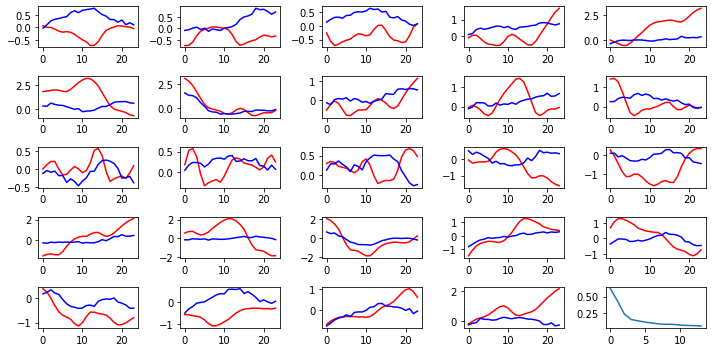

Step: 0, Train Loss: 0.05730476975440979
Step: 20, Train Loss: 0.060009490698575974
Step: 40, Train Loss: 0.0811711922287941
Step: 60, Train Loss: 0.04680926725268364
Step: 80, Train Loss: 0.03778471052646637
Step: 100, Train Loss: 0.0729256346821785
Step: 120, Train Loss: 0.06243482232093811
Step: 140, Train Loss: 0.05736570060253143
Epoch: 15, Train loss: 0.06106405282928927
acskill_socre:20.004881463181754, rmse_score:18.02088637477132
Epoch: 15, Valid Score: 1.9839950884104347


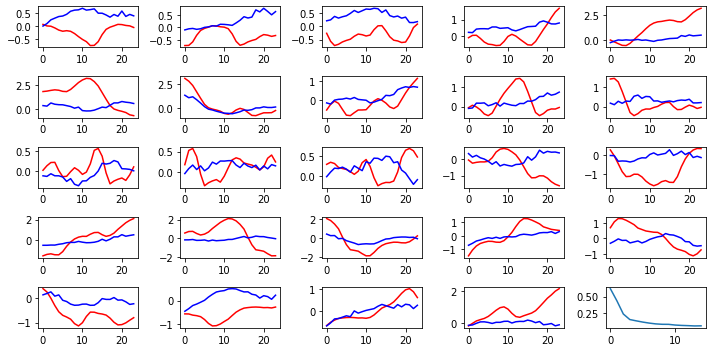

Step: 0, Train Loss: 0.06936085969209671
Step: 20, Train Loss: 0.07418385148048401
Step: 40, Train Loss: 0.12488216161727905
Step: 60, Train Loss: 0.03592340648174286
Step: 80, Train Loss: 0.06383830308914185
Step: 100, Train Loss: 0.043108731508255005
Step: 120, Train Loss: 0.031398504972457886
Step: 140, Train Loss: 0.061511747539043427
Epoch: 16, Train loss: 0.05728517069596134
acskill_socre:18.432606068666104, rmse_score:17.901648188118283
Epoch: 16, Valid Score: 0.5309578805478203


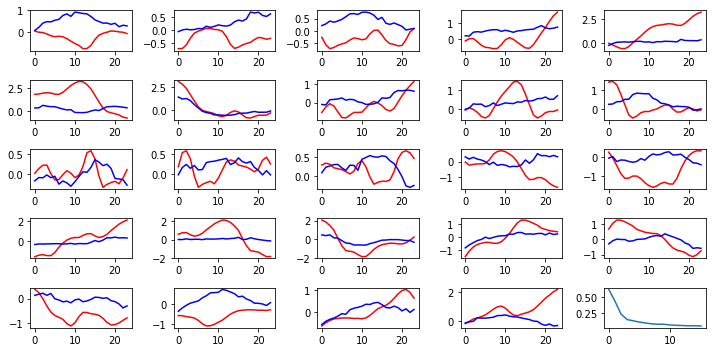

Step: 0, Train Loss: 0.04438440129160881
Step: 20, Train Loss: 0.02977169118821621
Step: 40, Train Loss: 0.05554657429456711
Step: 60, Train Loss: 0.07475021481513977
Step: 80, Train Loss: 0.11789761483669281
Step: 100, Train Loss: 0.05734030157327652
Step: 120, Train Loss: 0.04367053136229515
Step: 140, Train Loss: 0.03858521580696106
Epoch: 17, Train loss: 0.05281061258115997
acskill_socre:18.929883916018262, rmse_score:18.059744696354183
Epoch: 17, Valid Score: 0.8701392196640789


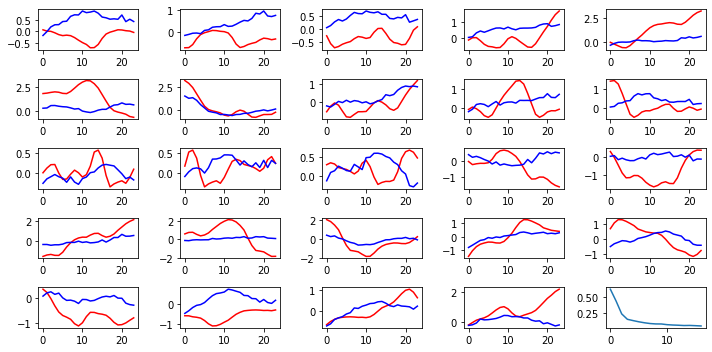

Step: 0, Train Loss: 0.06509740650653839
Step: 20, Train Loss: 0.04727870225906372
Step: 40, Train Loss: 0.045489758253097534
Step: 60, Train Loss: 0.05591348558664322
Step: 80, Train Loss: 0.11359702050685883
Step: 100, Train Loss: 0.07407709956169128
Step: 120, Train Loss: 0.046950578689575195
Step: 140, Train Loss: 0.054413847625255585
Epoch: 18, Train loss: 0.05192569066604523
acskill_socre:19.547227206949096, rmse_score:18.05848935472084
Epoch: 18, Valid Score: 1.4887378522282546


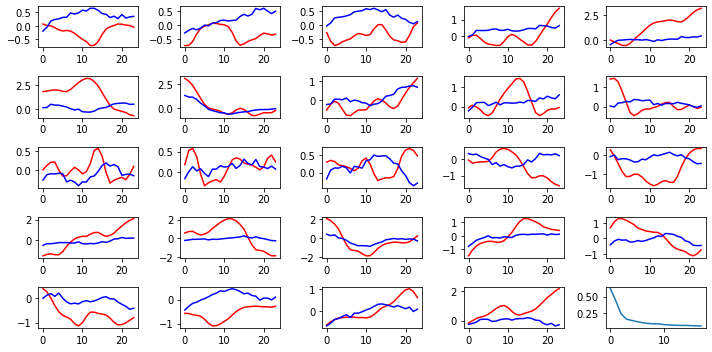

Step: 0, Train Loss: 0.03547744080424309
Step: 20, Train Loss: 0.03944861888885498
Step: 40, Train Loss: 0.026943564414978027
Step: 60, Train Loss: 0.06271176785230637
Step: 80, Train Loss: 0.09391467273235321
Step: 100, Train Loss: 0.03231362998485565
Step: 120, Train Loss: 0.07094272971153259
Step: 140, Train Loss: 0.061500560492277145
Epoch: 19, Train loss: 0.05134133823624212
acskill_socre:17.938049579894404, rmse_score:18.013665420820136
Epoch: 19, Valid Score: -0.0756158409257317


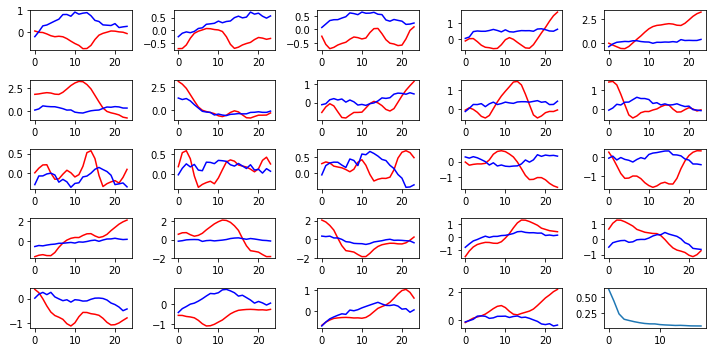

Step: 0, Train Loss: 0.0912741869688034
Step: 20, Train Loss: 0.04123276472091675
Step: 40, Train Loss: 0.03281531482934952
Step: 60, Train Loss: 0.056563787162303925
Step: 80, Train Loss: 0.036084506660699844
Step: 100, Train Loss: 0.04473809525370598
Step: 120, Train Loss: 0.046535708010196686
Step: 140, Train Loss: 0.06184583157300949
Epoch: 20, Train loss: 0.05217092070881635
acskill_socre:17.567171195221007, rmse_score:17.980077374828582
Epoch: 20, Valid Score: -0.4129061796075746


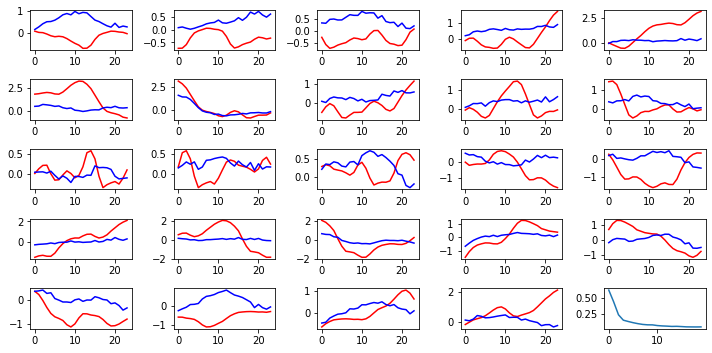

Step: 0, Train Loss: 0.060275256633758545
Step: 20, Train Loss: 0.04399723559617996
Step: 40, Train Loss: 0.05528131127357483
Step: 60, Train Loss: 0.06833287328481674
Step: 80, Train Loss: 0.11030413955450058
Step: 100, Train Loss: 0.041913293302059174
Step: 120, Train Loss: 0.034458454698324203
Step: 140, Train Loss: 0.03353576734662056
Epoch: 21, Train loss: 0.05115334309433421
acskill_socre:21.056633199311808, rmse_score:17.69726718875031
Epoch: 21, Valid Score: 3.359366010561498
Model saved successfully


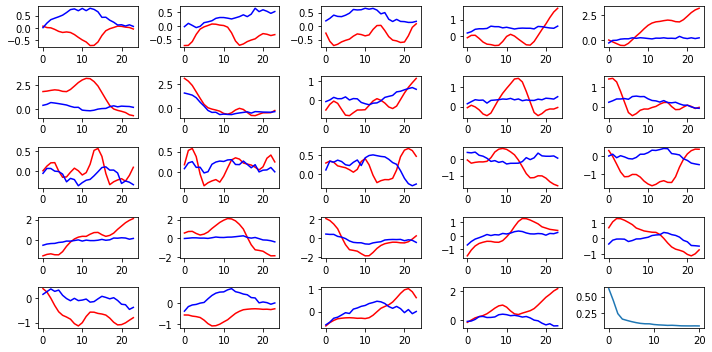

Step: 0, Train Loss: 0.048992931842803955
Step: 20, Train Loss: 0.03564789146184921
Step: 40, Train Loss: 0.025144312530755997
Step: 60, Train Loss: 0.05387718975543976
Step: 80, Train Loss: 0.030266940593719482
Step: 100, Train Loss: 0.04794804006814957
Step: 120, Train Loss: 0.03530146926641464
Step: 140, Train Loss: 0.034601714462041855
Epoch: 22, Train loss: 0.045838248073952655
acskill_socre:20.7637743014188, rmse_score:17.886359347590204
Epoch: 22, Valid Score: 2.8774149538285947


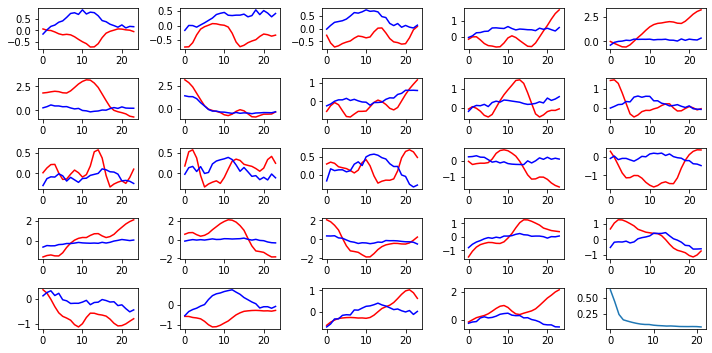

Step: 0, Train Loss: 0.05059501528739929
Step: 20, Train Loss: 0.03980862349271774
Step: 40, Train Loss: 0.022766202688217163
Step: 60, Train Loss: 0.038631752133369446
Step: 80, Train Loss: 0.030087333172559738
Step: 100, Train Loss: 0.02632511407136917
Step: 120, Train Loss: 0.03312363475561142
Step: 140, Train Loss: 0.03374410420656204
Epoch: 23, Train loss: 0.043953430341327024
acskill_socre:17.652014771597283, rmse_score:17.93246767531093
Epoch: 23, Valid Score: -0.2804529037136483


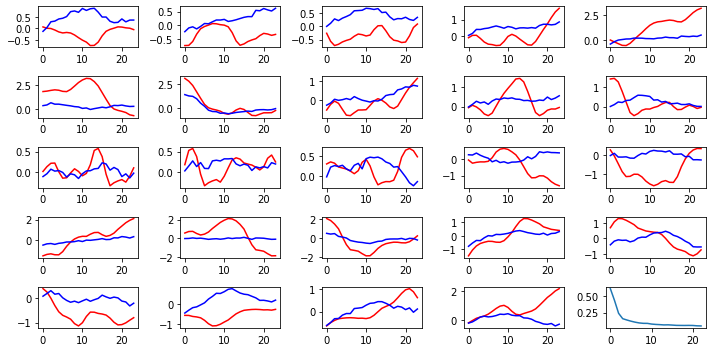

Step: 0, Train Loss: 0.03918427228927612
Step: 20, Train Loss: 0.018835149705410004
Step: 40, Train Loss: 0.06661153584718704
Step: 60, Train Loss: 0.026015518233180046
Step: 80, Train Loss: 0.03747601434588432
Step: 100, Train Loss: 0.06260976195335388
Step: 120, Train Loss: 0.03876281902194023
Step: 140, Train Loss: 0.06008986756205559
Epoch: 24, Train loss: 0.04030478911550894
acskill_socre:21.51819222843651, rmse_score:17.973764337175577
Epoch: 24, Valid Score: 3.544427891260934
Model saved successfully


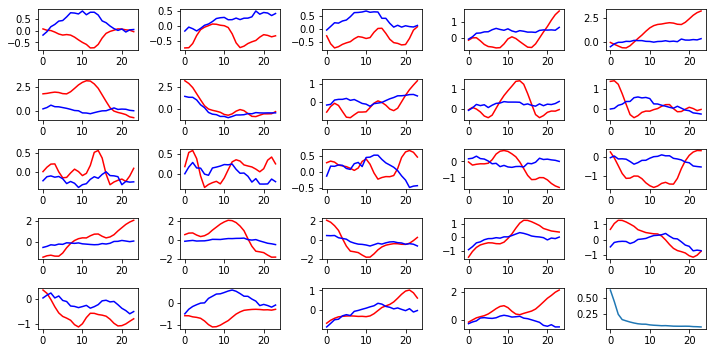

Step: 0, Train Loss: 0.04626917839050293
Step: 20, Train Loss: 0.024784065783023834
Step: 40, Train Loss: 0.05766349285840988
Step: 60, Train Loss: 0.03872349485754967
Step: 80, Train Loss: 0.026036258786916733
Step: 100, Train Loss: 0.04433542490005493
Step: 120, Train Loss: 0.033088479191064835
Step: 140, Train Loss: 0.08426939696073532
Epoch: 25, Train loss: 0.04327395041664577
acskill_socre:19.917159355378523, rmse_score:17.76936249596614
Epoch: 25, Valid Score: 2.1477968594123844


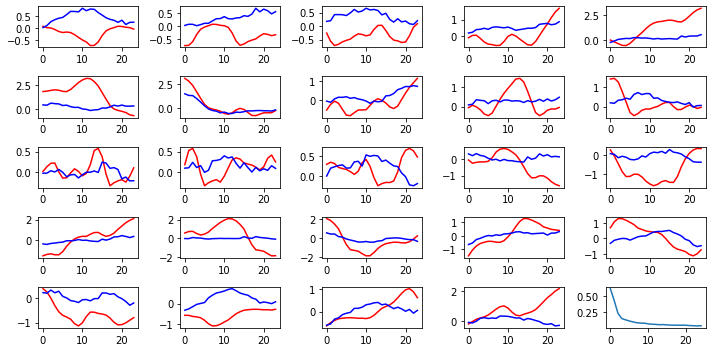

Step: 0, Train Loss: 0.04373069107532501
Step: 20, Train Loss: 0.024529926478862762
Step: 40, Train Loss: 0.03560208901762962
Step: 60, Train Loss: 0.05715898796916008
Step: 80, Train Loss: 0.03670539706945419
Step: 100, Train Loss: 0.03456847742199898
Step: 120, Train Loss: 0.02461812272667885
Step: 140, Train Loss: 0.02295278012752533
Epoch: 26, Train loss: 0.039161360274030735
acskill_socre:21.928566100759003, rmse_score:17.866765484407697
Epoch: 26, Valid Score: 4.061800616351306
Model saved successfully


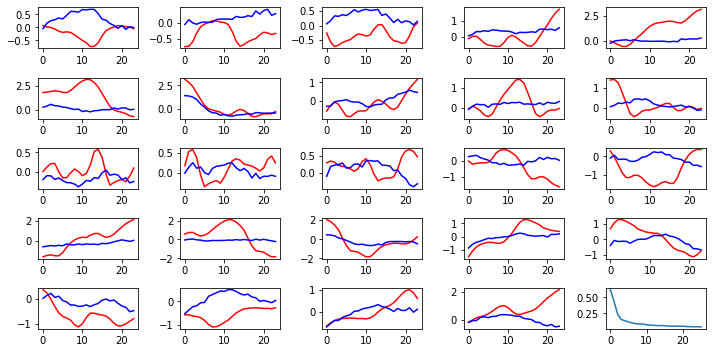

Step: 0, Train Loss: 0.04415082186460495
Step: 20, Train Loss: 0.06778054684400558
Step: 40, Train Loss: 0.024135982617735863
Step: 60, Train Loss: 0.03262029588222504
Step: 80, Train Loss: 0.020541656762361526
Step: 100, Train Loss: 0.03028876893222332
Step: 120, Train Loss: 0.048943400382995605
Step: 140, Train Loss: 0.0249430350959301
Epoch: 27, Train loss: 0.041698605294199026
acskill_socre:19.245815989205994, rmse_score:17.946355460178868
Epoch: 27, Valid Score: 1.299460529027126


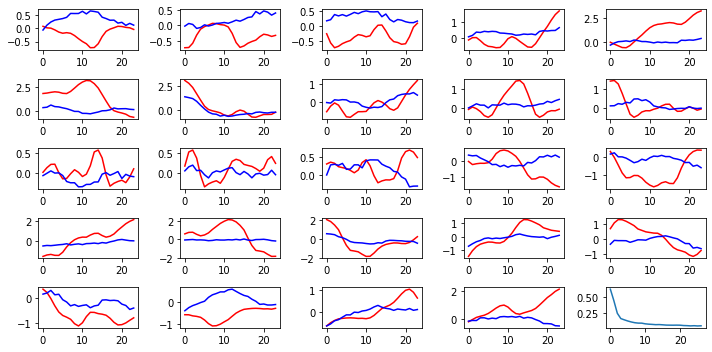

Step: 0, Train Loss: 0.03483106940984726
Step: 20, Train Loss: 0.04712187498807907
Step: 40, Train Loss: 0.039554089307785034
Step: 60, Train Loss: 0.032306697219610214
Step: 80, Train Loss: 0.02956165373325348
Step: 100, Train Loss: 0.02874586544930935
Step: 120, Train Loss: 0.06993451714515686
Step: 140, Train Loss: 0.04015504568815231
Epoch: 28, Train loss: 0.0409616421755046
acskill_socre:20.305073455745486, rmse_score:17.754359430069105
Epoch: 28, Valid Score: 2.550714025676381


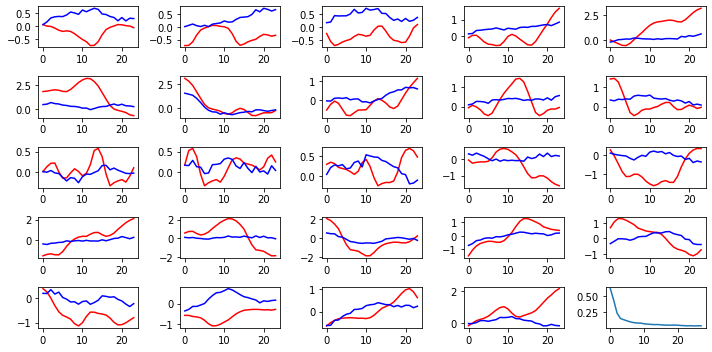

Step: 0, Train Loss: 0.059151630848646164
Step: 20, Train Loss: 0.03192584216594696
Step: 40, Train Loss: 0.021199088543653488
Step: 60, Train Loss: 0.04365534335374832
Step: 80, Train Loss: 0.027286391705274582
Step: 100, Train Loss: 0.04397853836417198
Step: 120, Train Loss: 0.03237456455826759
Step: 140, Train Loss: 0.03246186673641205
Epoch: 29, Train loss: 0.03723993990570307
acskill_socre:23.168268893344646, rmse_score:17.654280912552835
Epoch: 29, Valid Score: 5.513987980791811
Model saved successfully


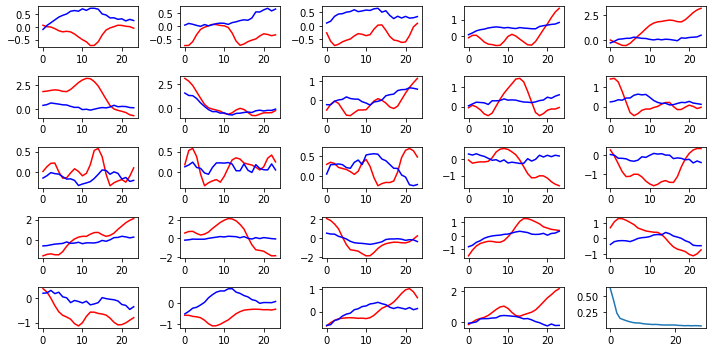

Step: 0, Train Loss: 0.03012092411518097
Step: 20, Train Loss: 0.024789568036794662
Step: 40, Train Loss: 0.025560390204191208
Step: 60, Train Loss: 0.031158115714788437
Step: 80, Train Loss: 0.030104300007224083
Step: 100, Train Loss: 0.02771761640906334
Step: 120, Train Loss: 0.029721369966864586
Step: 140, Train Loss: 0.04406736418604851
Epoch: 30, Train loss: 0.0372843095356573
acskill_socre:23.623961528526713, rmse_score:17.678399988568952
Epoch: 30, Valid Score: 5.945561539957762
Model saved successfully


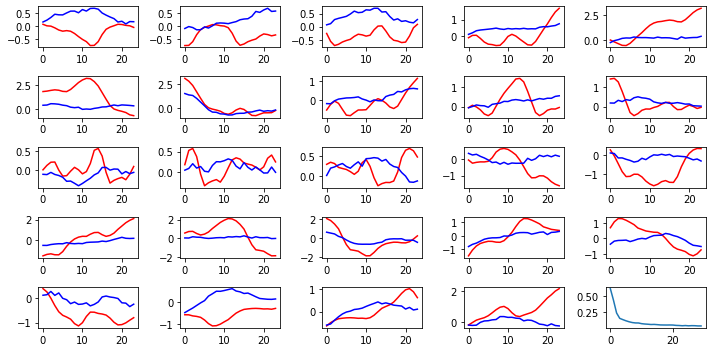

Step: 0, Train Loss: 0.0289735347032547
Step: 20, Train Loss: 0.04687964543700218
Step: 40, Train Loss: 0.0318874716758728
Step: 60, Train Loss: 0.032909780740737915
Step: 80, Train Loss: 0.04355195164680481
Step: 100, Train Loss: 0.024839621037244797
Step: 120, Train Loss: 0.020527709275484085
Step: 140, Train Loss: 0.021356597542762756
Epoch: 31, Train loss: 0.03865420424111494
acskill_socre:20.672198376489636, rmse_score:17.840637934117904
Epoch: 31, Valid Score: 2.8315604423717318


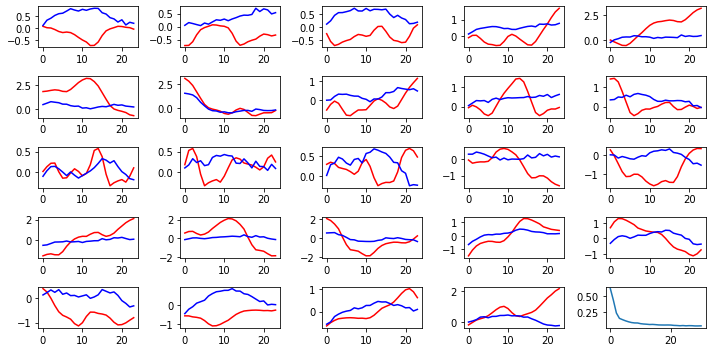

Step: 0, Train Loss: 0.02503991685807705
Step: 20, Train Loss: 0.04413997754454613
Step: 40, Train Loss: 0.044975146651268005
Step: 60, Train Loss: 0.03909222409129143
Step: 80, Train Loss: 0.05113004893064499
Step: 100, Train Loss: 0.026621349155902863
Step: 120, Train Loss: 0.021065613254904747
Step: 140, Train Loss: 0.03288651630282402
Epoch: 32, Train loss: 0.03650783374905586
acskill_socre:23.63284369244154, rmse_score:17.739637183119417
Epoch: 32, Valid Score: 5.893206509322123


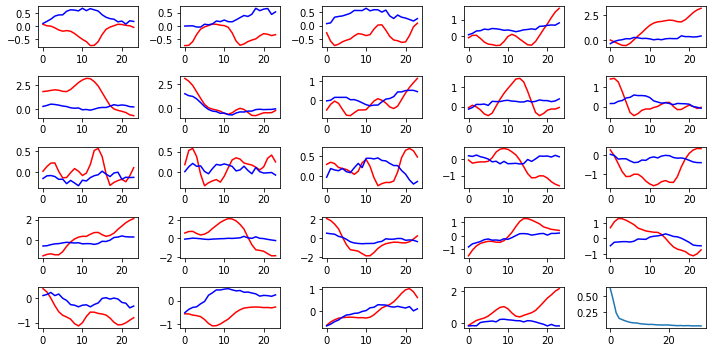

Step: 0, Train Loss: 0.02598819136619568
Step: 20, Train Loss: 0.049509286880493164
Step: 40, Train Loss: 0.031905028969049454
Step: 60, Train Loss: 0.033834926784038544
Step: 80, Train Loss: 0.029681606218218803
Step: 100, Train Loss: 0.03549824655056
Step: 120, Train Loss: 0.039080824702978134
Step: 140, Train Loss: 0.02613918110728264
Epoch: 33, Train loss: 0.03353451414365474
acskill_socre:22.32383955518584, rmse_score:17.816007088466847
Epoch: 33, Valid Score: 4.507832466718995


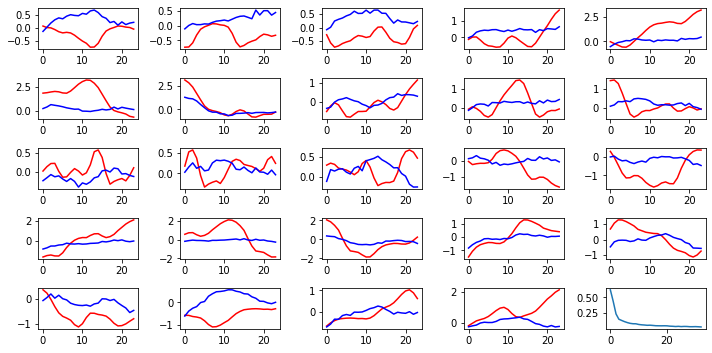

Step: 0, Train Loss: 0.028111381456255913
Step: 20, Train Loss: 0.029747694730758667
Step: 40, Train Loss: 0.023562707006931305
Step: 60, Train Loss: 0.032974500209093094
Step: 80, Train Loss: 0.04703056067228317
Step: 100, Train Loss: 0.027286654338240623
Step: 120, Train Loss: 0.04741077870130539
Step: 140, Train Loss: 0.04278421401977539
Epoch: 34, Train loss: 0.03268726704616661
acskill_socre:23.5526879227287, rmse_score:17.730471775476957
Epoch: 34, Valid Score: 5.822216147251744


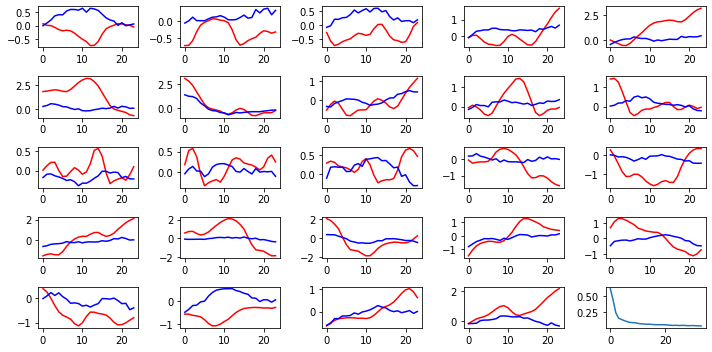

Step: 0, Train Loss: 0.02442616969347
Step: 20, Train Loss: 0.023585081100463867
Step: 40, Train Loss: 0.03253713250160217
Step: 60, Train Loss: 0.019444163888692856
Step: 80, Train Loss: 0.022237524390220642
Step: 100, Train Loss: 0.01643933728337288
Step: 120, Train Loss: 0.024822838604450226
Step: 140, Train Loss: 0.025315705686807632
Epoch: 35, Train loss: 0.0335248121226283
acskill_socre:26.65918582264348, rmse_score:17.62376069184506
Epoch: 35, Valid Score: 9.03542513079842
Model saved successfully


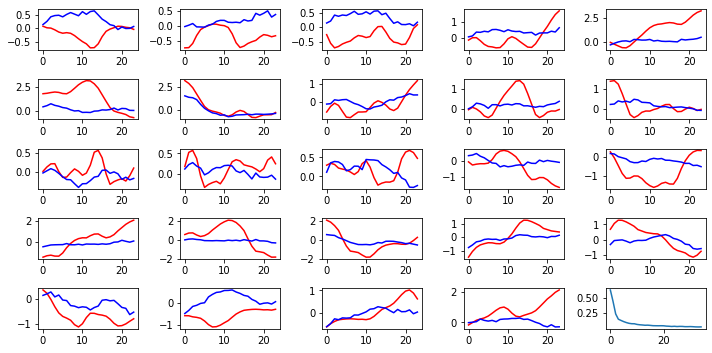

Step: 0, Train Loss: 0.027791788801550865
Step: 20, Train Loss: 0.03300268203020096
Step: 40, Train Loss: 0.02649523876607418
Step: 60, Train Loss: 0.020209629088640213
Step: 80, Train Loss: 0.024141624569892883
Step: 100, Train Loss: 0.05429255962371826
Step: 120, Train Loss: 0.015837429091334343
Step: 140, Train Loss: 0.06227707862854004
Epoch: 36, Train loss: 0.03329674653351715
acskill_socre:22.996549881822517, rmse_score:17.908304649157344
Epoch: 36, Valid Score: 5.088245232665173


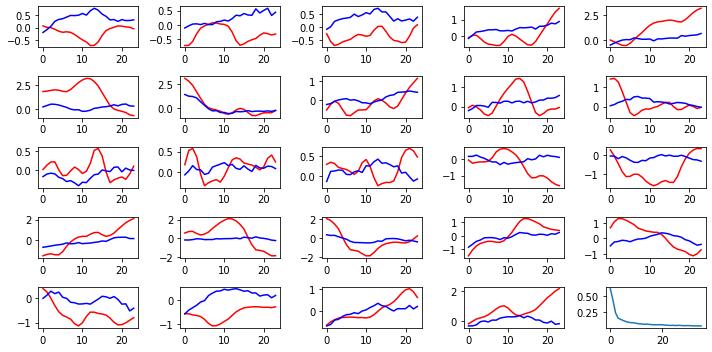

Step: 0, Train Loss: 0.020530520007014275
Step: 20, Train Loss: 0.027725523337721825
Step: 40, Train Loss: 0.04192984104156494
Step: 60, Train Loss: 0.06828241795301437
Step: 80, Train Loss: 0.03418461233377457
Step: 100, Train Loss: 0.04345029219985008
Step: 120, Train Loss: 0.019286613911390305
Step: 140, Train Loss: 0.07691596448421478
Epoch: 37, Train loss: 0.033675677825581944
acskill_socre:24.561432313832235, rmse_score:17.64769502063285
Epoch: 37, Valid Score: 6.913737293199386


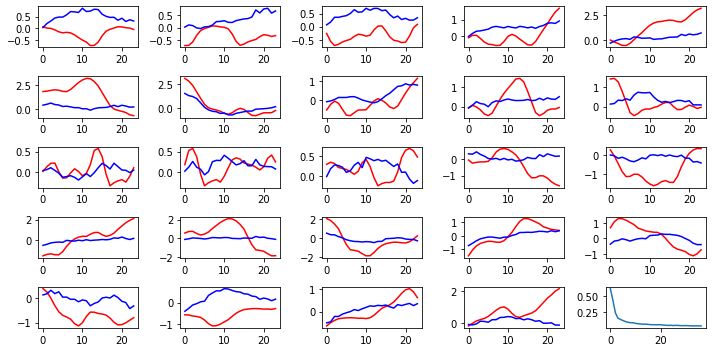

Step: 0, Train Loss: 0.035757146775722504
Step: 20, Train Loss: 0.01913153938949108
Step: 40, Train Loss: 0.02678886614739895
Step: 60, Train Loss: 0.031654905527830124
Step: 80, Train Loss: 0.02634747326374054
Step: 100, Train Loss: 0.016863303259015083
Step: 120, Train Loss: 0.02776811271905899
Step: 140, Train Loss: 0.015989910811185837
Epoch: 38, Train loss: 0.030117064140328807
acskill_socre:24.28520746601923, rmse_score:17.61828582272974
Epoch: 38, Valid Score: 6.666921643289491


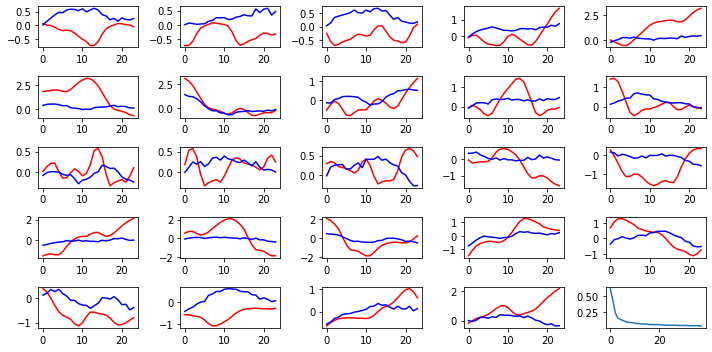

Step: 0, Train Loss: 0.02289855293929577
Step: 20, Train Loss: 0.03730127215385437
Step: 40, Train Loss: 0.06642279028892517
Step: 60, Train Loss: 0.03267812356352806
Step: 80, Train Loss: 0.031783655285835266
Step: 100, Train Loss: 0.017957769334316254
Step: 120, Train Loss: 0.020055416971445084
Step: 140, Train Loss: 0.0344947874546051
Epoch: 39, Train loss: 0.02937081440874975
acskill_socre:24.38706698913615, rmse_score:17.615709085025866
Epoch: 39, Valid Score: 6.771357904110285


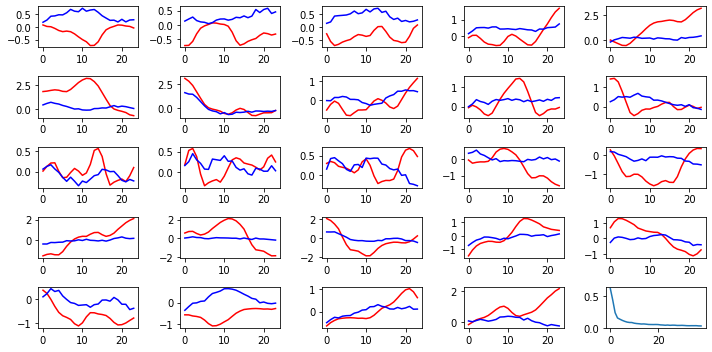

Step: 0, Train Loss: 0.021915439516305923
Step: 20, Train Loss: 0.03564842790365219
Step: 40, Train Loss: 0.02474815770983696
Step: 60, Train Loss: 0.036045100539922714
Step: 80, Train Loss: 0.027205780148506165
Step: 100, Train Loss: 0.03497236967086792
Step: 120, Train Loss: 0.030473992228507996
Step: 140, Train Loss: 0.026221536099910736
Epoch: 40, Train loss: 0.02868782863505695
acskill_socre:23.41348219233759, rmse_score:17.82326773757425
Epoch: 40, Valid Score: 5.590214454763341


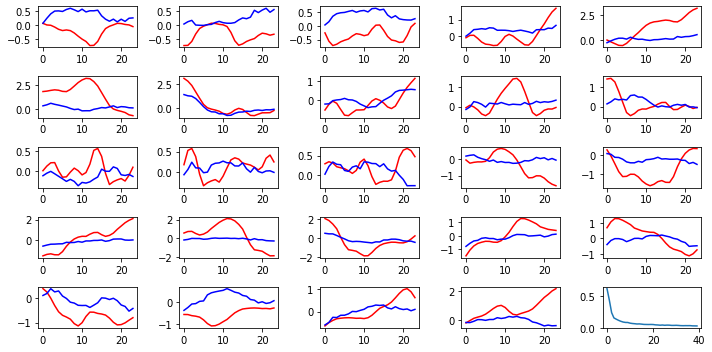

Step: 0, Train Loss: 0.01708494871854782
Step: 20, Train Loss: 0.022692717611789703
Step: 40, Train Loss: 0.02143503539264202
Step: 60, Train Loss: 0.07882725447416306
Step: 80, Train Loss: 0.048949018120765686
Step: 100, Train Loss: 0.02994459867477417
Step: 120, Train Loss: 0.031099896878004074
Step: 140, Train Loss: 0.039307333528995514
Epoch: 41, Train loss: 0.02764908098679495
acskill_socre:24.69560607087418, rmse_score:17.685019505935838
Epoch: 41, Valid Score: 7.010586564938343


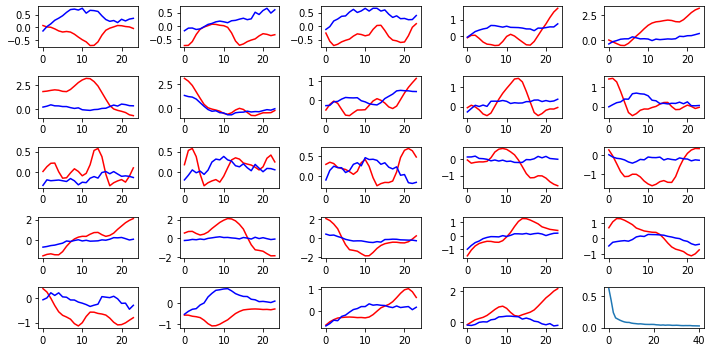

Step: 0, Train Loss: 0.02276778221130371
Step: 20, Train Loss: 0.03476623818278313
Step: 40, Train Loss: 0.04237055778503418
Step: 60, Train Loss: 0.03531260788440704
Step: 80, Train Loss: 0.023767691105604172
Step: 100, Train Loss: 0.017021361738443375
Step: 120, Train Loss: 0.024682968854904175
Step: 140, Train Loss: 0.013768492266535759
Epoch: 42, Train loss: 0.02831892303050789
acskill_socre:25.849509810027477, rmse_score:17.746964275680828
Epoch: 42, Valid Score: 8.10254553434665


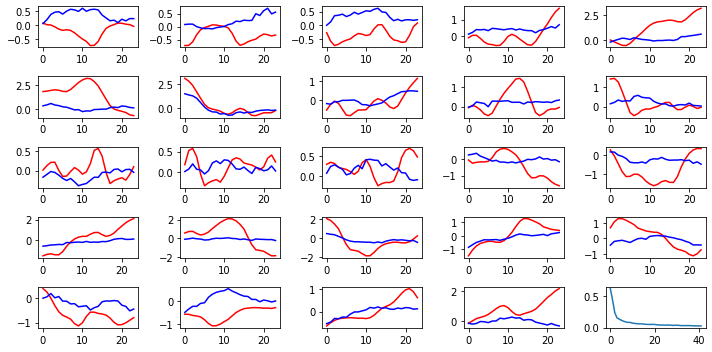

Step: 0, Train Loss: 0.01786101423203945
Step: 20, Train Loss: 0.019345078617334366
Step: 40, Train Loss: 0.039726853370666504
Step: 60, Train Loss: 0.017296534031629562
Step: 80, Train Loss: 0.015823369845747948
Step: 100, Train Loss: 0.019364124163985252
Step: 120, Train Loss: 0.01624348759651184
Step: 140, Train Loss: 0.017748810350894928
Epoch: 43, Train loss: 0.027747150357455425
acskill_socre:26.7486567339636, rmse_score:17.601614512838765
Epoch: 43, Valid Score: 9.147042221124835
Model saved successfully


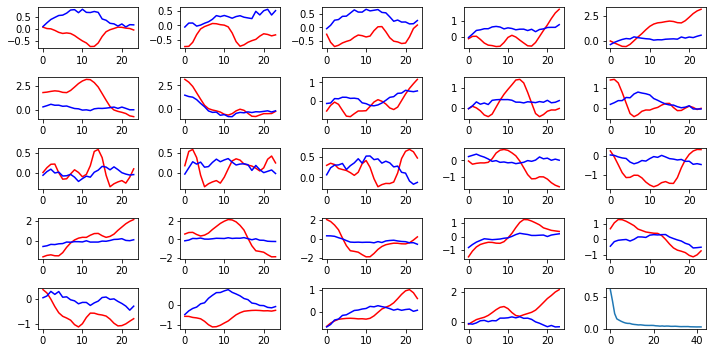

Step: 0, Train Loss: 0.01715555414557457
Step: 20, Train Loss: 0.014855317771434784
Step: 40, Train Loss: 0.02135692536830902
Step: 60, Train Loss: 0.025655873119831085
Step: 80, Train Loss: 0.01445167325437069
Step: 100, Train Loss: 0.02027658000588417
Step: 120, Train Loss: 0.015712110325694084
Step: 140, Train Loss: 0.017113590613007545
Epoch: 44, Train loss: 0.027316341361617796
acskill_socre:26.106836337439024, rmse_score:17.667739265181275
Epoch: 44, Valid Score: 8.439097072257749


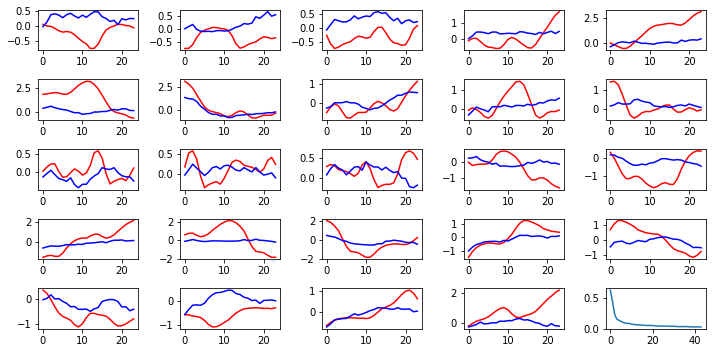

Step: 0, Train Loss: 0.013520412147045135
Step: 20, Train Loss: 0.030839737504720688
Step: 40, Train Loss: 0.020517028868198395
Step: 60, Train Loss: 0.03204718977212906
Step: 80, Train Loss: 0.03470349311828613
Step: 100, Train Loss: 0.05057201907038689
Step: 120, Train Loss: 0.0301448255777359
Step: 140, Train Loss: 0.018100326880812645
Epoch: 45, Train loss: 0.027785401255504726
acskill_socre:27.27169454171851, rmse_score:17.532939209968703
Epoch: 45, Valid Score: 9.738755331749807
Model saved successfully


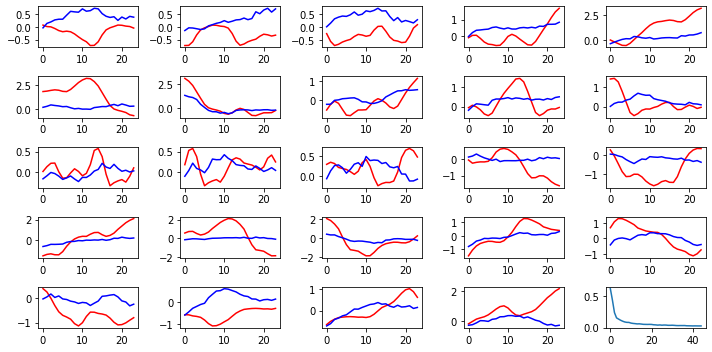

Step: 0, Train Loss: 0.0226132869720459
Step: 20, Train Loss: 0.028326084837317467
Step: 40, Train Loss: 0.022610608488321304
Step: 60, Train Loss: 0.04479626566171646
Step: 80, Train Loss: 0.04630297049880028
Step: 100, Train Loss: 0.028434446081519127
Step: 120, Train Loss: 0.016169089823961258
Step: 140, Train Loss: 0.026214852929115295
Epoch: 46, Train loss: 0.027383007708783835
acskill_socre:25.456990369142602, rmse_score:17.608934304925512
Epoch: 46, Valid Score: 7.84805606421709


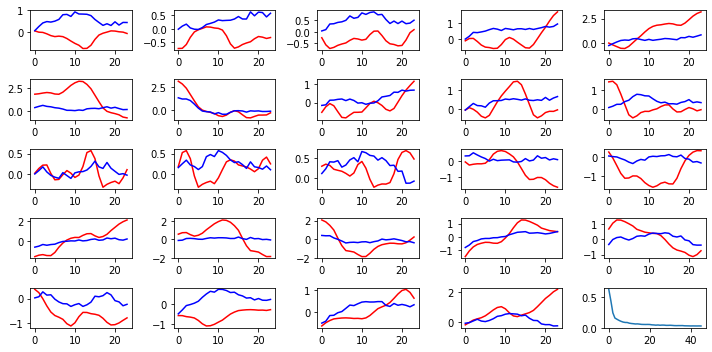

Step: 0, Train Loss: 0.03888329491019249
Step: 20, Train Loss: 0.035234905779361725
Step: 40, Train Loss: 0.02063075639307499
Step: 60, Train Loss: 0.03548876941204071
Step: 80, Train Loss: 0.0288468599319458
Step: 100, Train Loss: 0.015688177198171616
Step: 120, Train Loss: 0.05445560812950134
Step: 140, Train Loss: 0.02246108651161194
Epoch: 47, Train loss: 0.0283238277515422
acskill_socre:23.478035446572, rmse_score:17.946920556743333
Epoch: 47, Valid Score: 5.531114889828668


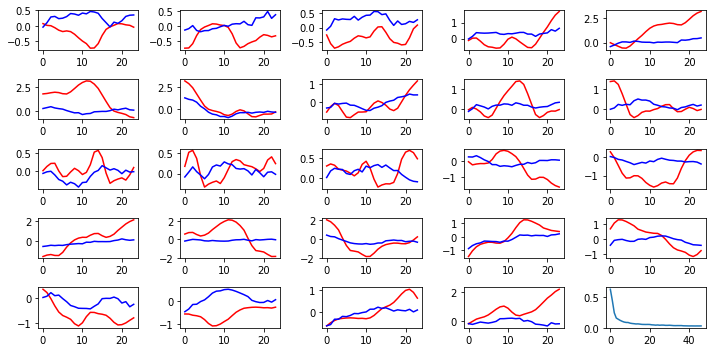

Step: 0, Train Loss: 0.02843901515007019
Step: 20, Train Loss: 0.019987329840660095
Step: 40, Train Loss: 0.02542000077664852
Step: 60, Train Loss: 0.03941735625267029
Step: 80, Train Loss: 0.020895402878522873
Step: 100, Train Loss: 0.04711846634745598
Step: 120, Train Loss: 0.033772289752960205
Step: 140, Train Loss: 0.0242098867893219
Epoch: 48, Train loss: 0.026893276893469976
acskill_socre:24.757805717015323, rmse_score:17.651960613071253
Epoch: 48, Valid Score: 7.10584510394407


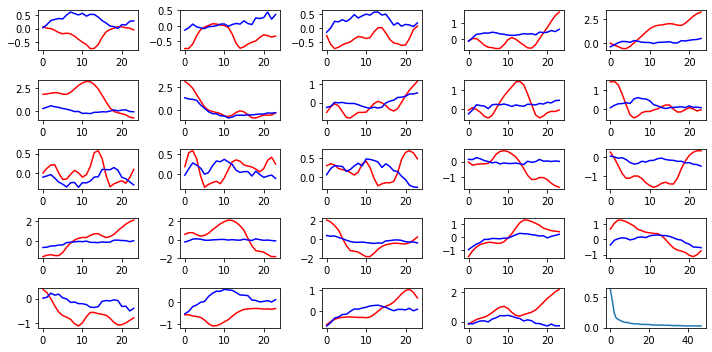

Step: 0, Train Loss: 0.05668135732412338
Step: 20, Train Loss: 0.018706385046243668
Step: 40, Train Loss: 0.01561851054430008
Step: 60, Train Loss: 0.033647529780864716
Step: 80, Train Loss: 0.03090684488415718
Step: 100, Train Loss: 0.0183691568672657
Step: 120, Train Loss: 0.020863808691501617
Step: 140, Train Loss: 0.020967787131667137
Epoch: 49, Train loss: 0.02796410872562699
acskill_socre:24.8934094237676, rmse_score:17.57994064575305
Epoch: 49, Valid Score: 7.313468778014549


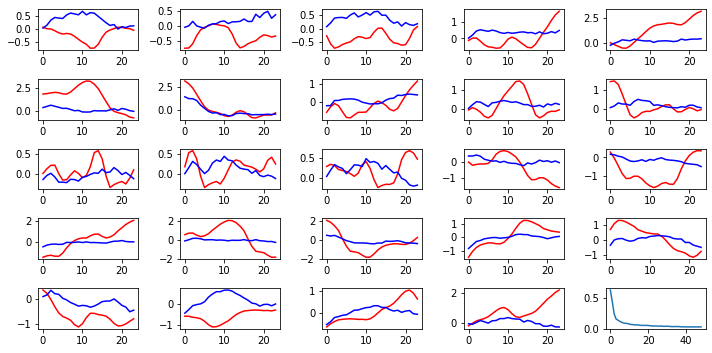

Step: 0, Train Loss: 0.011802248656749725
Step: 20, Train Loss: 0.02271469496190548
Step: 40, Train Loss: 0.01832638680934906
Step: 60, Train Loss: 0.02783518098294735
Step: 80, Train Loss: 0.030333589762449265
Step: 100, Train Loss: 0.020527763292193413
Step: 120, Train Loss: 0.047722600400447845
Step: 140, Train Loss: 0.014814957976341248
Epoch: 50, Train loss: 0.024363236023393804
acskill_socre:27.07950036885994, rmse_score:17.557731933301877
Epoch: 50, Valid Score: 9.521768435558062


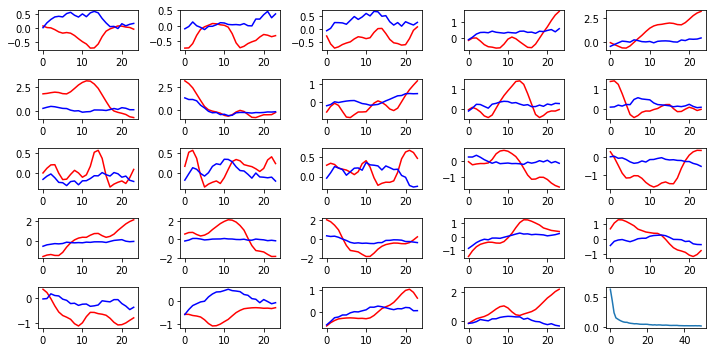

In [116]:
train(num_epochs=50)

In [ ]:
model.load_state_dict(torch.load('models/basemodel_epoch_5.pt'))

In [15]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [16]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
    data_list = [SST,T300,Ua,Va]
    SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

(20736, 4)


In [17]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [18]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [19]:
make_zip()